In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from datetime import datetime
from pandas.plotting import register_matplotlib_converters
import warnings
warnings.filterwarnings('ignore')

# A/B test стартовых историй приложения

В приложении с подпиской для чтения историй был проведен A/B-тест. Двум группам игроков были предложены разные стартовые истории при первом запуске приложения. Необходимо оценить результаты проведенного A/B-теста.

Основные пункты работы:

1. Подготовка данных
2. Анализ A/B теста
  1. Кумулятивная выручка по группам
  2. Кумулятивный средний чек по группам
  3. Кумулятивная конверсия по группам
  4. Относительное изменение кумулятивной конверсии группы B к группе A
  5. Количество платежей по пользователям
  6. Стоимость заказов
  7. Статистическая значимость различий в конверсии между группами
  8. Статистическая значимость различий в среднем чеке покупателя
  

## 1 Подготовка данных

In [68]:
payments = pd.read_csv('payments.csv')
sessions = pd.read_csv('sessions.csv')

In [69]:
payments.sample(10)

,#0 timestamp,#1 user id,#2 Event name,#3 is_trial,price
151,1514997900,59d54ad25638e80001b8befa,payment,False,2.99
2468,1516522800,80bbf662-d5dd-42ba-bc37-33f7fb764275,payment,False,7.99
1953,1516202400,59e37d245638e80001f0d225,payment,False,2.99
2615,1516561440,4617e52b-87cc-4e8a-aba7-d913b0b2fa4c,payment,True,0.00
3950,1517222400,e57af986-f647-4671-9a64-295a01b31be8,payment,False,7.99
3782,1517146500,02a57153-21ab-453f-92df-c3acf7b6dfe6,payment,False,7.99
2519,1516540500,54ab5fc9-999d-4c45-b761-446ff3148d7f,payment,False,7.99
2888,1516631400,e0ea27d7-70b6-4dbf-894d-3965ba135adb,payment,False,7.99
4008,1517242920,ba3e6604-3cab-4025-8bd6-ae4870afd58c,payment,False,7.99
1048,1515867780,7c309a84-24f3-4ba4-a4e2-d090e271a345,payment,True,0.00


In [70]:
sessions.sample(10)

,#0 timestamp,#1 user id,#2 Test group,#3 Event name
2037,1516479900,e4373ffa-c26e-4424-b693-69d4ddf4363d,05_12FTD_control_group,session start
6127,1517055120,85f33888-084d-4e3f-a0ee-779c5b9be22e,05_12FTD_test_group,session start
1487,1516421280,abed0e97-ef27-42e2-ac17-760ba6f2f27e,05_12FTD_control_group,session start
5154,1516904100,f7db8c05-f970-49e1-80bd-c89a308eddb3,05_12FTD_test_group,session start
3211,1516585380,0726161f-bb62-438b-89cb-28fb9bd81e8c,05_12FTD_control_group,session start
4157,1516732080,0b28712c-619e-4fe4-9eac-cc415cc44617,05_12FTD_control_group,session start
4720,1516826280,8eef4e4b-247e-40a5-9625-0179a6b31be3,05_12FTD_control_group,session start
4151,1516731660,17908287-e1f0-435c-9106-dbeea9ec3482,05_12FTD_test_group,session start
7797,1517359740,8eb1f2d7-30cd-4229-8d48-62bdc01cfc00,05_12FTD_test_group,session start
5936,1517019180,0d85ba00-112a-4cc5-a001-8469f028627f,05_12FTD_test_group,session start


In [71]:
payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4265 entries, 0 to 4264
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   #0 timestamp   4265 non-null   int64  
 1   #1 user id     4265 non-null   object 
 2   #2 Event name  4265 non-null   object 
 3   #3 is_trial    4265 non-null   bool   
 4   price          4265 non-null   float64
dtypes: bool(1), float64(1), int64(1), object(2)
memory usage: 137.6+ KB


In [72]:
sessions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8076 entries, 0 to 8075
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   #0 timestamp   8076 non-null   int64 
 1   #1 user id     8076 non-null   object
 2   #2 Test group  8076 non-null   object
 3   #3 Event name  8076 non-null   object
dtypes: int64(1), object(3)
memory usage: 252.5+ KB


In [73]:
def describe(df):
    for column in df.columns:
        if df[column].dtype == 'object':
        
            print(column)
        
            print()
        
            print(df[column].unique())
        
            print()
    
        else:
        
            print(column)
        
            print()
        
            print(df[column].describe())
        
            print()

In [74]:
describe(payments)

#0 timestamp

count    4.265000e+03
mean     1.516267e+09
std      6.751001e+05
min      1.514754e+09
25%      1.515871e+09
50%      1.516393e+09
75%      1.516823e+09
max      1.517432e+09
Name: #0 timestamp, dtype: float64

#1 user id

['59c856ca5638e80001b8bad2' '32eb44a1-4c44-49e1-8322-253ef00ac52c'
 'acfaee6d-abe2-4c8c-a243-98331eb5a736' ...
 '0e6ae29b-2056-4d2b-94cf-853bc66d779a'
 'b9e6387f-9a66-4951-b569-6f42185d52c0'
 '80378737-946c-4309-b2ff-bdef513ff815']

#2 Event name

['payment']

#3 is_trial

count     4265
unique       2
top       True
freq      2263
Name: #3 is_trial, dtype: object

price

count    4265.000000
mean        3.452982
std         4.159743
min         0.000000
25%         0.000000
50%         0.000000
75%         7.990000
max        39.990000
Name: price, dtype: float64



In [75]:
describe(sessions)

#0 timestamp

count    8.076000e+03
mean     1.516759e+09
std      3.408544e+05
min      1.514769e+09
25%      1.516479e+09
50%      1.516713e+09
75%      1.517038e+09
max      1.517432e+09
Name: #0 timestamp, dtype: float64

#1 user id

['ab3a0b4e-6286-4748-90a1-e7d58273594d'
 'e64698c1-0168-4523-9592-f5226e63b9e6'
 'a8436498-ca01-4f09-9bac-de1bf217e00e' ...
 'e6130b35-ee13-495d-89e0-5a7c6af5a981'
 '6c5a4326-3668-4f82-8d8a-5dc43132ff5d'
 'd21e2ee9-290d-4d1f-b749-3558db98d32b']

#2 Test group

['05_12FTD_control_group' '05_12FTD_test_group']

#3 Event name

['session start']



Переименуем столбцы для удобства

In [76]:
payments.columns.tolist()

['#0 timestamp', '#1 user id', '#2 Event name', '#3 is_trial', 'price']

In [77]:
payments = payments.rename(columns = {'#0 timestamp':'timestamp', '#1 user id':'uid', '#2 Event name':'event_name', '#3 is_trial':'is_trial',  'price':'price'})

In [78]:
sessions.columns.tolist()

['#0 timestamp', '#1 user id', '#2 Test group', '#3 Event name']

In [79]:
sessions = sessions.rename(columns = {'#0 timestamp':'session_start', '#1 user id':'uid', '#2 Test group':'test_group', '#3 Event name':'session'})

In [80]:
sessions.sample(10)

,session_start,uid,test_group,session
6590,1517118540,4facc7bb-1598-4b7c-9ff3-d4c3216b8d37,05_12FTD_control_group,session start
820,1516354200,4b93108c-4d95-4997-a6cf-1a6ec48ca939,05_12FTD_test_group,session start
3802,1516668180,35b8181c-aede-4bd1-921b-d36a54c3d267,05_12FTD_test_group,session start
3382,1516617840,939c8d81-fff0-4c56-b0a8-f623e779b8ff,05_12FTD_control_group,session start
7865,1517370840,d378cea5-1755-489d-8ba8-bd35e73d799f,05_12FTD_test_group,session start
1175,1516395600,22a15d75-02d9-403b-89e7-1539591f7ad1,05_12FTD_test_group,session start
7277,1517252940,7fc31023-d56e-4a67-9d5f-e47dfb3b47ab,05_12FTD_test_group,session start
5415,1516931820,cb3f13e3-4d7e-4b4b-81c7-48e04a2986f2,05_12FTD_control_group,session start
2054,1516481340,2c4753b6-efda-4a33-899f-4a2ca285e85b,05_12FTD_control_group,session start
185,1516291980,8cea0e08-07fe-4d69-85ac-37d13a65231f,05_12FTD_test_group,session start


In [81]:
payments.duplicated().sum()

0

In [82]:
sessions.duplicated().sum()

0

Дубликатов нет

In [83]:
payments['timestamp']= pd.to_datetime(payments['timestamp'], unit='s')
payments['timestamp'] = pd.to_datetime(payments['timestamp'], format='%Y-%m-%d')
payments['date'] = (payments['timestamp']).dt.date
payments.sample(5)

,timestamp,uid,event_name,is_trial,price,date
1809,2018-01-16 08:45:00,bba51423-3e31-41f5-89de-555d739a7158,payment,False,7.99,2018-01-16
271,2018-01-05 22:00:00,9c32ce04-bcc5-4ddb-ab3e-b9858f148256,payment,False,7.99,2018-01-05
746,2018-01-09 00:16:00,966c335d-96bc-4d87-a5c6-40d1139bdf65,payment,True,0.00,2018-01-09
3356,2018-01-25 11:49:00,5e3601d7-d168-448d-becc-b23768db611e,payment,True,0.00,2018-01-25
397,2018-01-07 01:05:00,c5547ae8-efdd-42ec-802f-4f8d1e59d0ca,payment,False,7.99,2018-01-07


In [84]:
sessions['session_start']= pd.to_datetime(sessions['session_start'], unit='s')
sessions['session_start'] = pd.to_datetime(sessions['session_start'], format='%Y-%m-%dT%H:%M:%S')
sessions['date'] = (sessions['session_start']).dt.date

sessions.sample(5)

,session_start,uid,test_group,session,date
3217,2018-01-22 01:48:00,0287dd67-191d-4091-92ca-2ed23e1340c8,05_12FTD_control_group,session start,2018-01-22
2519,2018-01-21 08:04:00,c381aee0-6852-4b05-ae7f-61f6e6f1beeb,05_12FTD_test_group,session start,2018-01-21
7752,2018-01-30 22:59:00,91bb9f2e-204e-44ad-824a-31e11451a72f,05_12FTD_test_group,session start,2018-01-30
7561,2018-01-30 13:11:00,2a671f83-0e45-4137-bc62-045b8955d3d3,05_12FTD_control_group,session start,2018-01-30
4831,2018-01-25 00:01:00,b740cb1a-1486-4aff-a9d1-d881b981fb64,05_12FTD_test_group,session start,2018-01-25


In [85]:
test=sessions[sessions['test_group'] == '05_12FTD_test_group']
control=sessions[sessions['test_group'] == '05_12FTD_control_group'] 

In [86]:
print('Кол-во уникальных пользователей в общем массиве: {}'.format(sessions['uid'].nunique()))
print('Кол-во уникальных пользователей в тестовой группе: {}'.format(test['uid'].nunique()))
print('Кол-во уникальных пользователей в контрольной группе: {}'.format(control['uid'].nunique()))

Кол-во уникальных пользователей в общем массиве: 2218
Кол-во уникальных пользователей в тестовой группе: 1163
Кол-во уникальных пользователей в контрольной группе: 1055


Пользователи в тестовой и контрольной группах не пересекаются

## 2 Анализ A/B теста

### 2.1 Кумулятивная выручка по группам

Исключать из таблицы с платежами пробные подписки не будем, т.к. они тоже являются индикатором привлечения клиентов.

In [87]:
#В таблицу с платежами добавим информацию о принадлежности юзера к тестовой или контрольной группе
group = sessions.groupby('uid')['test_group'].unique().to_frame()
group.sample(5)

,test_group
uid,
c95c0dc5-d889-46dc-aa12-d6b1a8e4c5a1,[05_12FTD_test_group]
d8c76924-d80a-4661-9a2e-bc29331d67b8,[05_12FTD_test_group]
64bbedff-6339-4288-8cd4-1fb87e9b0059,[05_12FTD_test_group]
9bd54fa5-149a-428f-aeab-f7d8289f5926,[05_12FTD_control_group]
8ffa1c7c-5d0d-40ab-a7b1-c5cc3bfd1215,[05_12FTD_test_group]


In [88]:
payments=payments.merge(group,on='uid')
payments.sample(10)

,timestamp,uid,event_name,is_trial,price,date,test_group
232,2018-01-28 22:42:00,a5cd720a-8cd0-42e9-aa91-583af0e4d31d,payment,True,0.00,2018-01-28,[05_12FTD_control_group]
54,2018-01-14 16:05:00,08d9dcad-4ca4-465e-bbb2-ea5a76b15a0b,payment,False,7.99,2018-01-14,[05_12FTD_test_group]
235,2018-01-30 10:20:00,8ffa1c7c-5d0d-40ab-a7b1-c5cc3bfd1215,payment,False,7.99,2018-01-30,[05_12FTD_test_group]
18,2018-01-04 19:11:00,4baa9387-c164-499a-97b7-4ea13c0c6d4d,payment,False,7.99,2018-01-04,[05_12FTD_control_group]
194,2018-01-19 20:53:00,7efc4405-1a94-4260-8ca0-bb9fc5060775,payment,True,0.00,2018-01-19,[05_12FTD_control_group]
52,2018-01-07 01:01:00,08d9dcad-4ca4-465e-bbb2-ea5a76b15a0b,payment,True,0.00,2018-01-07,[05_12FTD_test_group]
182,2018-01-16 22:03:00,daa593c1-a14b-4dd4-b4c0-07d0e2cd78d5,payment,True,0.00,2018-01-16,[05_12FTD_control_group]
168,2018-01-21 11:20:00,520b29b6-d453-4cfe-a999-1a79a596c825,payment,False,7.99,2018-01-21,[05_12FTD_control_group]
6,2018-01-08 20:35:00,c9a6e320-3d41-4547-961b-ba58ce7797d8,payment,False,7.99,2018-01-08,[05_12FTD_test_group]
41,2018-01-06 16:31:00,9bf3db77-170a-467a-b5ae-14bcc17f281f,payment,True,0.00,2018-01-06,[05_12FTD_control_group]


In [89]:
def test_group(row): 
    group = row['test_group']
    if group == '05_12FTD_control_group':
            return 0
    if group == '05_12FTD_test_group':
            return 1
payments['test_group'] = payments.apply(test_group, axis = 1)


Итого, имеем 239 платежей.

Чтобы исключить проблему подсматривания, проанализируем графики накапливаемых данных.

In [90]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = payments[['date','test_group']].drop_duplicates()
datesGroups.head(5)

,date,test_group
0,2017-12-31,1
1,2018-01-08,1
3,2018-01-01,0
4,2018-01-08,0
5,2018-01-01,1


In [91]:
# получаем агрегированные кумулятивные по дням данные о транзакциях 

ordersAggregated = datesGroups.apply(lambda x: payments[np.logical_and(payments['date'] <= x['date'], payments['test_group'] == x['test_group'])].agg({'date' : 'max', 'test_group' : 'max', 'event_name' : pd.Series.count, 'uid' : pd.Series.nunique, 'price' : 'sum'}), axis=1).sort_values(by=['date','test_group'])
ordersAggregated.head(5)

,date,test_group,event_name,uid,price
0,2017-12-31,1,1,1,0.00
3,2018-01-01,0,1,1,0.00
5,2018-01-01,1,3,3,0.00
15,2018-01-02,0,2,2,7.99
10,2018-01-02,1,7,6,55.97


In [92]:
sessions['test_group'] = sessions.apply(test_group, axis = 1)

In [122]:
# получаем агрегированные кумулятивные по дням данные о посетителях  
visitorsAggregated = datesGroups.apply(lambda x: sessions[np.logical_and(sessions['date'] <= x['date'], sessions['test_group'] == x['test_group'])].agg({'date' : 'max', 'test_group' : 'max', 'uid' : 'nunique'}), axis=1).sort_values(by=['date','test_group'])
visitorsAggregated=visitorsAggregated.drop_duplicates()
visitorsAggregated.head(5)

,date,test_group,uid
3,2018-01-01,0.0,4.0
5,2018-01-01,1.0,1.0
4,2018-01-02,0.0,5.0
10,2018-01-02,1.0,1.0
19,2018-01-03,1.0,2.0


In [121]:
# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'test_group'], right_on=['date', 'test_group'])
cumulativeData.columns = ['date', 'test_group', 'payments', 'buyers', 'revenue', 'visitors']
cumulativeData.head(5)

,date,test_group,payments,buyers,revenue,visitors
0,2018-01-01,0,1,1,0.00,4.0
1,2018-01-01,1,3,3,0.00,1.0
2,2018-01-02,0,2,2,7.99,5.0
3,2018-01-02,1,7,6,55.97,1.0
4,2018-01-03,1,9,8,55.97,2.0


In [118]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['test_group']==1][['date','revenue', 'payments']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['test_group']==0][['date','revenue', 'payments']]

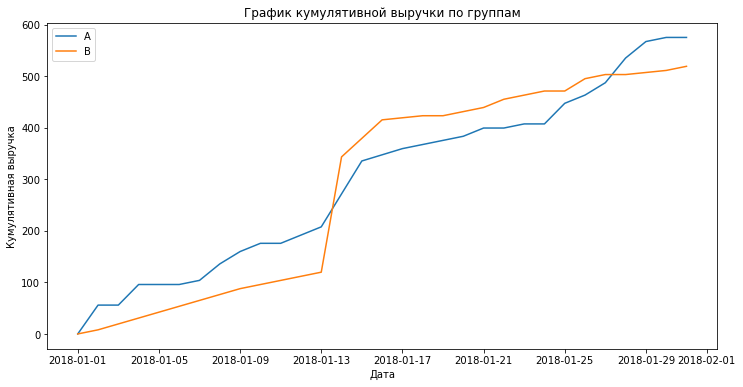

In [119]:
plt.figure(figsize = (12, 6))
plt.title('График кумулятивной выручки по группам')
plt.xlabel('Дата')
plt.ylabel('Кумулятивная выручка')

# Строим график выручки группы А
fig = plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
fig = plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.legend()

График выручки двух групп увеличивается в течение всего периода и находится примерно на одном уровне по двум группам. Однако график выручки группы B резко и значительно вырос примерно 13.01.2018. Это может сигнализировать о всплеске числа платных подписок(после окончания пробного периода), либо о появлении очень дорогих покупок в выборке.

### 2.2 Кумулятивный средний чек по группам

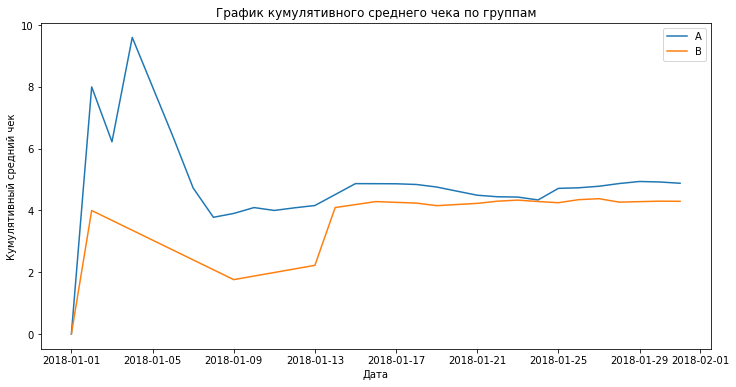

In [120]:
# разделим кумулятивную выручку на кумулятивное число платежей
plt.figure(figsize = (12, 6))
plt.title('График кумулятивного среднего чека по группам')
plt.xlabel('Дата')
plt.ylabel('Кумулятивный средний чек')
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['payments'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['payments'], label='B')
plt.legend() 

Из данного графика видно, что всплеск общей выручки группы B связан не с увеличением среднего чека клиента, а с увеличением числа платящих клиентов. В тестовой группе A, наоборот, были аномальные суммы платежей на клиента в начале тестирования. 

В середине теста графики стабилизировались. Средней чек группы А больше, чем у группы В. Но поскольку могли иметь место выбросы, мы снова не можем сделать вывод о преимуществе какой-либо из групп.

### 2.3 Кумулятивная конверсия по группам

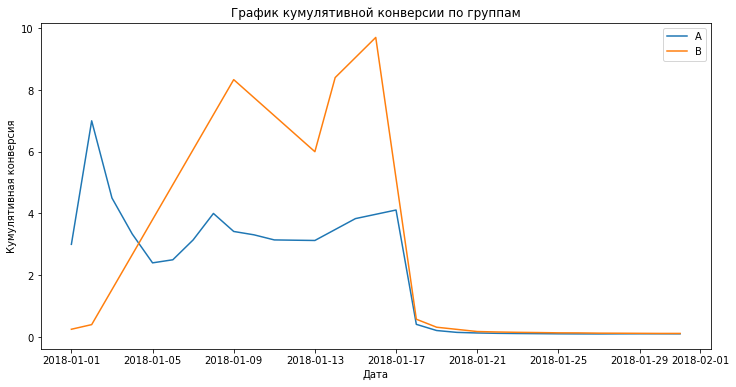

In [98]:
plt.figure(figsize = (12, 6))
plt.title('График кумулятивной конверсии по группам')
plt.xlabel('Дата')
plt.ylabel('Кумулятивная конверсия')

# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['payments']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['test_group']==1]

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['test_group']==0]

# строим графики
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()



График демонстрирует всплеск конверсии 17.01.2018 по двум группам, в особенности по группе B, где покупок стало значительно больше, чем уникальных пользователей. Стартовая сраница действительно привлекла пользователей.

Несмотря на увеличивающуюся выручку, конверсия в транзакцию значительно снизилась к концу теста и сравнялась по обеим группам. Можем сделать вывод, что стартовая страница не оправдала ожидания пользователей от сервиса, поэтому новых стало меньше.

### 2.4 Относительное изменение кумулятивной конверсии группы B к группе A

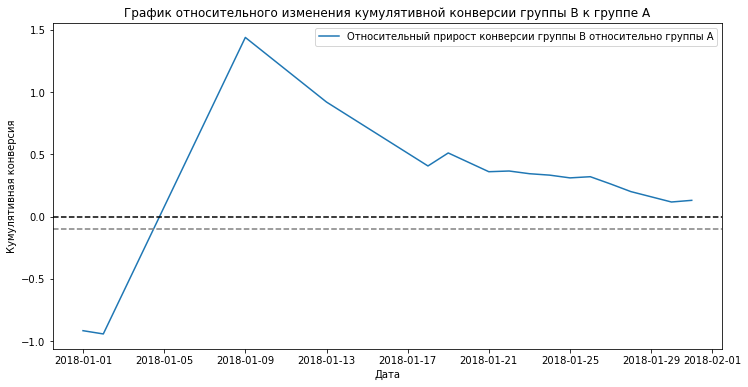

In [99]:
plt.figure(figsize = (12, 6))
plt.title('График относительного изменения кумулятивной конверсии группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('Кумулятивная конверсия')

mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

mergedCumulativeConversions=mergedCumulativeConversions.dropna()

plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")
plt.legend()

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=-0.1, color='grey', linestyle='--') 

По данному графику видим, что преимущество по конверсии остается за группой B к концу теста.

### 2.5 Количество платежей по пользователям

Результаты теста могут искажаться аномалиями. Изучим распределения данных, чтобы выявить эти аномальные значения.

In [100]:
paymentsByUsers = payments.drop(['test_group', 'price', 'date'], axis=1).groupby('uid', as_index=False).agg({'event_name' : pd.Series.count})

paymentsByUsers.columns = ['uid','payments']

(array([48.,  0.,  0.,  0.,  0., 55.,  0.,  0.,  0., 27.]),
 array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. ]),
 <BarContainer object of 10 artists>)

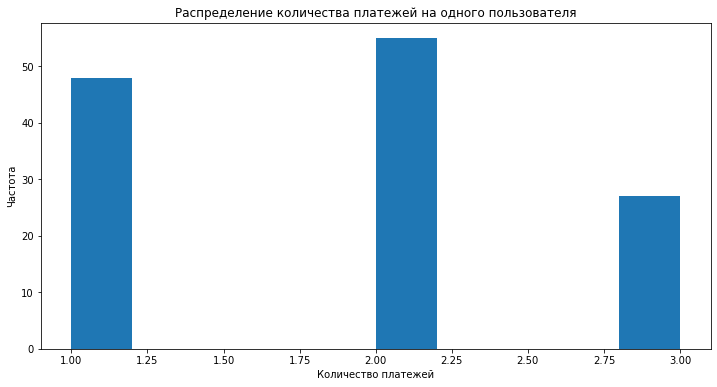

In [101]:
plt.figure(figsize = (12, 6))
plt.title('Распределение количества платежей на одного пользователя')
plt.xlabel('Количество платежей')
plt.ylabel('Частота')
plt.hist(paymentsByUsers['payments'])

Пользователи, как правило совершают 1-2 платежа.

Принято исключать отсеивать от 1% до 5% наблюдений с крайними значениями. Расчитаем 95 и 99 перцентили, чтобы определить, является ли 3 платежа аномальным значением.

In [102]:
print(np.percentile(paymentsByUsers['payments'], [95, 99])) 

[3. 3.]


Значение попадает на 99 перцентиль, значит аномальным значением не является.

### 2.6 Стоимость заказов

Анологично отображаем распределение стоимости заказов.

(array([114., 122.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   3.]),
 array([ 0.   ,  3.999,  7.998, 11.997, 15.996, 19.995, 23.994, 27.993,
        31.992, 35.991, 39.99 ]),
 <BarContainer object of 10 artists>)

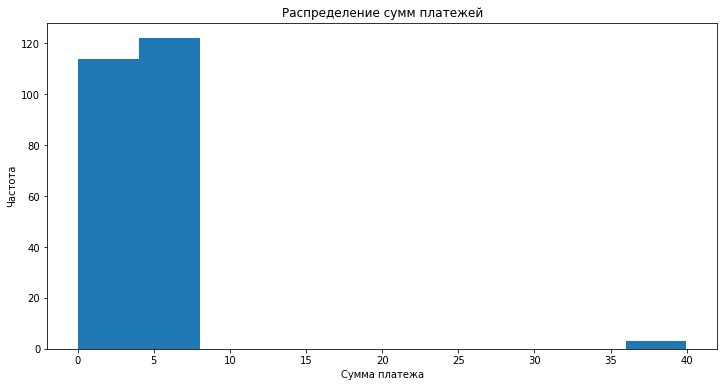

In [103]:
plt.figure(figsize = (12, 6))
plt.title('Распределение сумм платежей')
plt.xlabel('Сумма платежа')
plt.ylabel('Частота')
plt.hist(payments['price']) 

Чаще всего стоимость заказа не превышает 13 долларов. Сложно определить точную границу выбросов, поэтому также находим 95 и 99 перцентили.

In [104]:
print(np.percentile(payments['price'], [95, 99])) 

[ 7.99 27.83]


С помощью перцентилей убеждаемся, что имеются выбросы примерно от 26 долларов. Избавимся от них, чтобы не искажать итог:

In [105]:
payments= payments[payments['price']<=26]

### 2.7 Статистическая значимость различий в конверсии между группами

Так как значения имеют распределение отличное от нормального, применим статистический критерий Манна-Уитни к выборкам.

In [106]:
visitorsADaily = sessions[sessions['test_group']==1][['date', 'uid']]
visitorsADaily= visitorsADaily.groupby('date')['uid'].agg('nunique').reset_index()
visitorsADaily.columns = ['date', 'visitorsPerDateA'] #  количество пользователей в выбранную дату в группе A

visitorsACummulative = visitorsADaily.apply(lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg({'date' : 'max', 'visitorsPerDateA' : 'sum'}), axis=1)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA'] # количество пользователей до выбранной даты включительно в группе A

visitorsBDaily = sessions[sessions['test_group']==0][['date', 'uid']]
visitorsBDaily= visitorsBDaily.groupby('date')['uid'].agg('nunique').reset_index()
visitorsBDaily.columns = ['date', 'visitorsPerDateB'] #  количество пользователей в выбранную дату в группе B

visitorsBCummulative = visitorsBDaily.apply(lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg({'date' : 'max', 'visitorsPerDateB' : 'sum'}), axis=1)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB'] # количество пользователей до выбранной даты включительно в группе B


In [107]:
paymentsADaily = payments[payments['test_group']==1][['date', 'event_name', 'uid', 'price']]\
    .groupby('date', as_index=False)\
    .agg({'event_name' : pd.Series.count, 'price' : 'sum'})
paymentsADaily.columns = ['date', 'paymentsPerDateA', 'revenuePerDateA']  # количество заказов в выбранную дату и суммарная выручка в группе A

paymentsACummulative = paymentsADaily.apply(
    lambda x: \
        paymentsADaily[paymentsADaily['date'] <= x['date']]\
            .agg({
                'date' : 'max',
                'paymentsPerDateA' : 'sum',
                'revenuePerDateA' : 'sum'}), axis=1).sort_values(by=['date'])
paymentsACummulative.columns = ['date', 'paymentsCummulativeA', 'revenueCummulativeA'] # суммарная выручка до выбранной даты включительно в группе A

paymentsBDaily = payments[payments['test_group']==0][['date', 'event_name', 'uid', 'price']]\
    .groupby('date', as_index=False)\
    .agg({'event_name' : pd.Series.count, 'price' : 'sum'})
paymentsBDaily.columns = ['date', 'paymentsPerDateB', 'revenuePerDateB'] # количество заказов в выбранную дату и суммарная выручка в группе B

paymentsBCummulative = paymentsBDaily.apply(
    lambda x: \
        paymentsBDaily[paymentsBDaily['date'] <= x['date']]\
            .agg({
                'date' : 'max',
                'paymentsPerDateB' : 'sum',
                'revenuePerDateB' : 'sum'}), axis=1).sort_values(by=['date'])
paymentsBCummulative.columns = ['date', 'paymentsCummulativeB', 'revenueCummulativeB'] # суммарная выручка до выбранной даты включительно в группе B


In [108]:
data = paymentsADaily.merge(paymentsBDaily, left_on='date', right_on='date', how='left')\
    .merge(paymentsACummulative, left_on='date', right_on='date', how='left')\
    .merge(paymentsBCummulative, left_on='date', right_on='date', how='left')\
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')\
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')\
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')\
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
data.sample(5)

,date,paymentsPerDateA,revenuePerDateA,paymentsPerDateB,revenuePerDateB,paymentsCummulativeA,revenueCummulativeA,paymentsCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
28,2018-01-30,2,7.99,1.0,7.99,114,455.43,119.0,511.36,99.0,118.0,2281.0,2167.0
10,2018-01-11,1,0.00,1.0,7.99,42,95.88,53.0,111.86,2.0,NaN,18.0,NaN
29,2018-01-31,1,0.00,2.0,7.99,115,455.43,121.0,519.35,98.0,74.0,2379.0,2241.0
27,2018-01-29,5,31.96,NaN,NaN,112,447.44,NaN,NaN,117.0,113.0,2182.0,2049.0
22,2018-01-23,2,7.99,1.0,7.99,90,327.59,107.0,463.42,161.0,157.0,1293.0,1167.0


In [109]:
# укажем число совершенных заказов для пользователей по группам
paymentsByUsersA = payments[payments['test_group']==1].groupby('uid', as_index=False).agg({'event_name' : pd.Series.count})
paymentsByUsersA.columns = ['uid', 'payments']

paymentsByUsersB = payments[payments['test_group']==0].groupby('uid', as_index=False).agg({'event_name' : pd.Series.count})
paymentsByUsersB.columns = ['uid', 'payments']

Объявим переменные sampleA и sampleB, в которых пользователям из разных групп будет соответствовать количество заказов. Тем, кто ничего не заказал, будут соответствовать нули. Это нужно, чтобы подготовить выборки к проверке критерием Манна-Уитни.

In [110]:
sampleA = pd.concat([paymentsByUsersA['payments'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(paymentsByUsersA['payments'])), name='payments')],axis=0)

sampleB = pd.concat([paymentsByUsersB['payments'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(paymentsByUsersB['payments'])), name='payments')],axis=0) 

Так как значения имеют распределение отличное от нормального, применим статистический критерий Манна-Уитни.

Так как объем выборок больше 1000, задаем критический уровень значимости = 0,001.

##### Нулевая гипотеза: статистически значимых различий в конверсии между группами нет.

##### Альтернативная гипотеза: статистически значимые различия в конверсии между группами есть.

In [111]:
print("p-value: {0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1])) # критерий Манна-Уитни

print("Относительный прирост конверсии группы B: {0:.3f}".format(sampleB.mean()/sampleA.mean()-1)) 

p-value: 0.418
Относительный прирост конверсии группы B: 0.121


p-value больше 0.05, следовательно, нулевую гипотезу не отвергаем. Между группами отсутствуют статистически значимые различия в конверсии.

Различие конверсии в данном случае составляет 12.1%, но мы не можем утверждать, что группа B лучше.

### 2.8 Статистическая значимость различий в среднем чеке покупателя

##### Нулевая гипотеза: статистически значимых различий в среднем чеке между группами нет.

##### Альтернативная гипотеза: статистически значимые различия в среднем чеке между группами есть.

In [112]:
print("p-value: {0:.3f}".format(stats.mannwhitneyu(payments[payments['test_group']==1]['price'], payments[payments['test_group']==0]['price'])[1]))

print("Относительный прирост среднего чека группы B: {0:.3f}".format(payments[payments['test_group']==0]['price'].mean()/payments[payments['test_group']==1]['price'].mean()-1))

p-value: 0.262
Относительный прирост среднего чека группы B: 0.084


Различие среднего чека составляет 8.4% в пользу группы B.

Но при этом `p-value` больше 0.001, Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет.


## Вывод

Были проанализированы данные по двум группам: контрольной и тестовой.
    
Прежде всего, необходимо было исключить проблему подсматривания. Расчитав накопительные `выручку`,`средний чек` и `конверсию`, мы убедились, что графики стабилизировались и тест можно считать завершенным. 

Относительные различия данных метрик по двум группам показали, что небольшое преимущество у группы B, несмотря на то что в начале теста группа А имела значительный всплеск по сумме среднего чека.

Проверив данные на наличие выбросов, было обнаружено, что группа А имеет аномальные значения среднего чека, поэтому менее 5% таких значений были исключены для более объективного результата.

Для определения статистической значимости был применен статистический критерий Манна-Уитни, т.к. распределения данных по суммам платежа и кол-ву платежей на пользователя являются отличными от нормального.

При сравнении контрольной группы с экспериментальной статистически значимых различий не обнаружено.

##### Таким образом, измененить стартовую историю в приложении возможно, это не ухудшит конверсию. Но и не улучшит.